In [2]:
import pandas as pd 
df = pd.read_csv("..//static//csv//heart_2020_cleaned.csv")
print(df.columns)

display(df.head(10))

Index(['HeartDisease', 'BMI', 'Smoking', 'AlcoholDrinking', 'Stroke',
       'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory',
       'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'SleepTime',
       'Asthma', 'KidneyDisease', 'SkinCancer'],
      dtype='object')


HeartDisease    BMI Smoking AlcoholDrinking Stroke  PhysicalHealth  \
0           No  16.60     Yes              No     No             3.0   
1           No  20.34      No              No    Yes             0.0   
2           No  26.58     Yes              No     No            20.0   
3           No  24.21      No              No     No             0.0   
4           No  23.71      No              No     No            28.0   
5          Yes  28.87     Yes              No     No             6.0   
6           No  21.63      No              No     No            15.0   
7           No  31.64     Yes              No     No             5.0   
8           No  26.45      No              No     No             0.0   
9           No  40.69      No              No     No             0.0   

   MentalHealth DiffWalking     Sex  AgeCategory   Race  \
0          30.0          No  Female        55-59  White   
1           0.0          No  Female  80 or older  White   
2          30.0          No    Male        65-69  White   
3           0.0          No  Female        75-79  White   
4           0.0         Yes  Female        40-44  White   
5           0.0         Yes  Female        75-79  Black   
6           0.0          No  Female        70-74  White   
7           0.0         Yes  Female  80 or older  White   
8           0.0          No  Female  80 or older  White   
9           0.0         Yes    Male        65-69  White   

                  Diabetic PhysicalActivity  GenHealth  SleepTime Asthma  \
0                      Yes              Yes  Very good        5.0    Yes   
1                       No              Yes  Very good        7.0     No   
2                      Yes              Yes       Fair        8.0    Yes   
3                       No               No       Good        6.0     No   
4                       No              Yes  Very good        8.0     No   
5                       No               No       Fair       12.0     No   
6                       No              Yes       Fair        4.0    Yes   
7                      Yes               No       Good        9.0    Yes   
8  No, borderline diabetes               No       Fair        5.0     No   
9                       No              Yes       Good       10.0     No   

  KidneyDisease SkinCancer  
0            No        Yes  
1            No         No  
2            No         No  
3            No        Yes  
4            No         No  
5            No         No  
6            No        Yes  
7            No         No  
8           Yes         No  
9            No         No

## Регрессия

Цель: Разработать модель регрессии, которая будет предсказывать количество часов сна, которое человек получает в сутки, на основе его демографических данных, образа жизни и состояния здоровья.

Применение:

Медицинские учреждения: Модель может помочь врачам оценить качество сна пациента и разработать индивидуальные планы лечения и профилактики нарушений сна.

Компании, разрабатывающие приложения для отслеживания сна: Модель может использоваться для улучшения своих продуктов и предоставления более точных рекомендаций.

Исследования в области сна: Модель может помочь в изучении факторов, влияющих на качество сна.

Сначала подготовим данные для работы - удалим выбросы.

In [34]:
import pandas as pd
from scipy import stats

data = pd.read_csv("..//static//csv//heart_2020_cleaned.csv").head(1000)

numeric_features = ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']

z_scores = stats.zscore(data[numeric_features])

threshold = 3

data_cleaned = data[(z_scores < threshold).all(axis=1)]
data = data_cleaned
print("Размер данных до удаления выбросов:", data.shape)
print("Размер данных после удаления выбросов:", data_cleaned.shape)

Размер данных до удаления выбросов: (929, 18)
Размер данных после удаления выбросов: (929, 18)


Теперь перейдем к делению на выборки и созданию ориентира

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

features = ['BMI', 'Smoking', 'AlcoholDrinking', 'Stroke', 'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer']
target = 'SleepTime'

global X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.2, random_state=42)

print("Размер обучающей выборки:", X_train.shape)
print("Размер тестовой выборки:", X_test.shape)

baseline_predictions = [y_train.mean()] * len(y_test)

print('Baseline MAE:', mean_absolute_error(y_test, baseline_predictions))
print('Baseline MSE:', mean_squared_error(y_test, baseline_predictions))
print('Baseline R²:', r2_score(y_test, baseline_predictions))

Размер обучающей выборки: (255836, 16)
Размер тестовой выборки: (63959, 16)
Baseline MAE: 1.0154101277944922
Baseline MSE: 2.085820163563156
Baseline R²: -7.204157852269688e-05


Создание конвейера и обучение моделей

In [21]:
import pandas as pd
from scipy import stats
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

categorical_features = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer']
numeric_features = ['BMI', 'PhysicalHealth', 'MentalHealth']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)])

pipeline_linear_regression = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())])

pipeline_decision_tree = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))])

pipeline_gradient_boosting = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))])

pipelines = [
    ('Linear Regression', pipeline_linear_regression),
    ('Decision Tree', pipeline_decision_tree),
    ('Gradient Boosting', pipeline_gradient_boosting)
]

for name, pipeline in pipelines:
    pipeline.fit(X_train, y_train)
    print(f"Model: {name} trained.")

Model: Linear Regression trained.
Model: Decision Tree trained.
Model: Gradient Boosting trained.


Оценка качества моделей

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

for name, pipeline in pipelines:
    y_pred = pipeline.predict(X_test)
    print(f"Model: {name}")
    print('MAE:', mean_absolute_error(y_test, y_pred))
    print('MSE:', mean_squared_error(y_test, y_pred))
    print('R²:', r2_score(y_test, y_pred))
    print()

Model: Linear Regression
MAE: 0.999721882988516
MSE: 2.007024248723743
R²: 0.03770762552704621

Model: Decision Tree
MAE: 1.405790088390023
MSE: 4.053338792508978
R²: -0.9434229624615185

Model: Gradient Boosting
MAE: 0.9962143800804221
MSE: 1.9983219431838193
R²: 0.041880052575063775



Линейная регрессия имеет низкое смещение, так как MAE и MSE близки к 1. Однако, R² близок к 0, что указывает на то, что модель не очень хорошо объясняет дисперсию в данных. Это может быть связано с тем, что линейная модель не может хорошо аппроксимировать сложные зависимости в данных.

Дерево решений имеет высокое смещение и дисперсию. Отрицательный R² указывает на то, что модель работает хуже, чем простое предсказание среднего значения. Это свидетельствует о переобучении и высокой дисперсии.

Градиентный бустинг имеет низкое смещение, так как MAE и MSE близки к 1. R² также близок к 0, что указывает на то, что модель не очень хорошо объясняет дисперсию в данных. Однако, это лучший результат среди всех моделей, что указывает на то, что градиентный бустинг лучше справляется с данными, чем линейная регрессия.

Линейная регрессия и Градиентный бустинг имеют низкое смещение, но низкий R², что указывает на то, что они не могут хорошо объяснить дисперсию в данных.

Дерево решений имеет высокую дисперсию и переобучение, что приводит к отрицательному R².

## Классификация

Цель: Разработать модель, которая сможет предсказывать вероятность развития сердечно-сосудистых заболеваний (HeartDisease) у пациентов на основе их демографических данных, образа жизни и состояния здоровья.

Применение: Модель может использоваться в медицинских учреждениях для раннего выявления пациентов с высоким риском сердечных заболеваний, что позволит назначить профилактические меры и улучшить результаты лечения.

Проведем деление на выборки и создание ориентира

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

features = ['BMI', 'Smoking', 'AlcoholDrinking', 'Stroke', 'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer']
target = 'HeartDisease'

X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.2, random_state=42)

print("Размер обучающей выборки:", X_train.shape)
print("Размер тестовой выборки:", X_test.shape)

Размер обучающей выборки: (743, 16)
Размер тестовой выборки: (186, 16)


In [ ]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

features = ['BMI', 'Smoking', 'AlcoholDrinking', 'Stroke', 'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer']
target = 'HeartDisease'

label_encoder = LabelEncoder()
data[target] = label_encoder.fit_transform(data[target])

categorical_features = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer']
numeric_features = ['BMI', 'PhysicalHealth', 'MentalHealth']

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X = preprocessor.fit_transform(data[features])
y = data[target]

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(pd.Series(y_resampled).value_counts())

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=1) 
    recall = recall_score(y_test, y_pred, pos_label=1)  
    f1 = f1_score(y_test, y_pred, pos_label=1)  
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }

logreg_param_dist = {
    'classifier__C': uniform(loc=0, scale=4),
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']
}

logreg_pipeline = Pipeline([
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

logreg_random_search = RandomizedSearchCV(logreg_pipeline, param_distributions=logreg_param_dist, n_iter=50, cv=5, random_state=42, n_jobs=-1)
logreg_random_search.fit(X_train, y_train)

print("Лучшие гиперпараметры для логистической регрессии:")
print(logreg_random_search.best_params_)

logreg_best_model = logreg_random_search.best_estimator_
logreg_results = evaluate_model(logreg_best_model, X_test, y_test)

rf_param_dist = {
    'classifier__n_estimators': randint(100, 1000),
    'classifier__max_depth': [None] + list(randint(10, 100).rvs(10)),
    'classifier__min_samples_split': randint(2, 20),
    'classifier__min_samples_leaf': randint(1, 20),
    'classifier__bootstrap': [True, False]
}

rf_pipeline = Pipeline([
    ('classifier', RandomForestClassifier(random_state=42))
])

rf_random_search = RandomizedSearchCV(rf_pipeline, param_distributions=rf_param_dist, n_iter=50, cv=5, random_state=42, n_jobs=-1)
rf_random_search.fit(X_train, y_train)

print("Лучшие гиперпараметры для случайного леса:")
print(rf_random_search.best_params_)

rf_best_model = rf_random_search.best_estimator_
rf_results = evaluate_model(rf_best_model, X_test, y_test)

gb_param_dist = {
    'classifier__n_estimators': randint(100, 1000),
    'classifier__learning_rate': uniform(0.01, 0.5),
    'classifier__max_depth': [None] + list(randint(10, 100).rvs(10)),
    'classifier__min_samples_split': randint(2, 20),
    'classifier__min_samples_leaf': randint(1, 20),
    'classifier__subsample': uniform(0.5, 0.5)
}

gb_pipeline = Pipeline([
    ('classifier', GradientBoostingClassifier(random_state=42))
])

gb_random_search = RandomizedSearchCV(gb_pipeline, param_distributions=gb_param_dist, n_iter=50, cv=5, random_state=42, n_jobs=-1)
gb_random_search.fit(X_train, y_train)

print("Лучшие гиперпараметры для градиентного бустинга:")
print(gb_random_search.best_params_)

gb_best_model = gb_random_search.best_estimator_
gb_results = evaluate_model(gb_best_model, X_test, y_test)

print("\nРезультаты моделей:")
print("\nLogistic Regression:")
for metric, value in logreg_results.items():
    print(f"{metric.capitalize()}: {value:.4f}")

print("\nRandom Forest:")
for metric, value in rf_results.items():
    print(f"{metric.capitalize()}: {value:.4f}")

print("\nGradient Boosting:")
for metric, value in gb_results.items():
    print(f"{metric.capitalize()}: {value:.4f}")

HeartDisease
0    796
1    796
Name: count, dtype: int64
Размер обучающей выборки: (1273, 49)
Размер тестовой выборки: (319, 49)
Лучшие гиперпараметры для логистической регрессии:
{'classifier__C': np.float64(0.7272998688284025), 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Accuracy: 0.7398
Precision: 0.7239
Recall: 0.7564
F1-Score: 0.7398
ROC-AUC: 0.8338
Лучшие гиперпараметры для случайного леса:
{'classifier__bootstrap': True, 'classifier__max_depth': np.int64(32), 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 6, 'classifier__n_estimators': 317}
Accuracy: 0.9122
Precision: 0.9571
Recall: 0.8590
F1-Score: 0.9054
ROC-AUC: 0.9773
Лучшие гиперпараметры для градиентного бустинга:
{'classifier__learning_rate': np.float64(0.17269984907963387), 'classifier__max_depth': np.int64(96), 'classifier__min_samples_leaf': 8, 'classifier__min_samples_split': 8, 'classifier__n_estimators': 294, 'classifier__subsample': np.float64(0.8288064461501716)}
Accuracy: 

Logistic Regression Metrics:
Accuracy: 0.7398
Precision: 0.7239
Recall: 0.7564
F1-Score: 0.7398
ROC-AUC: 0.8338


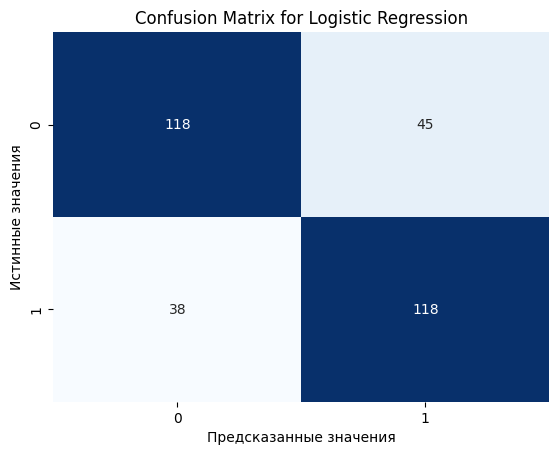

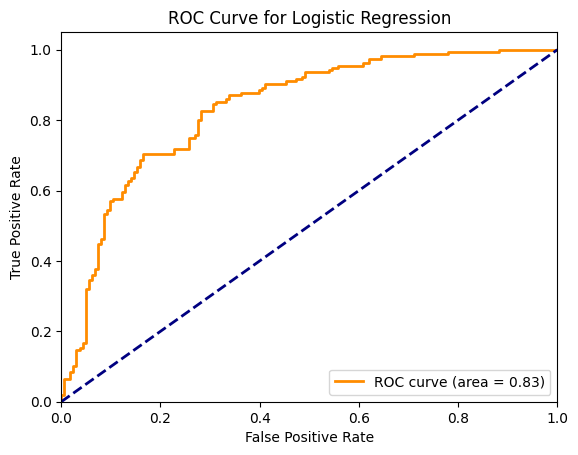

Random Forest Metrics:
Accuracy: 0.9122
Precision: 0.9571
Recall: 0.8590
F1-Score: 0.9054
ROC-AUC: 0.9773


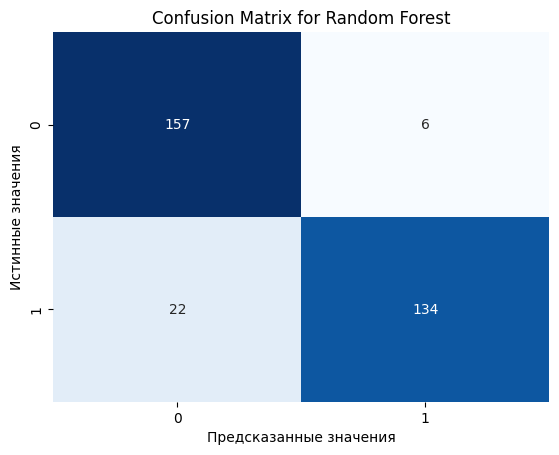

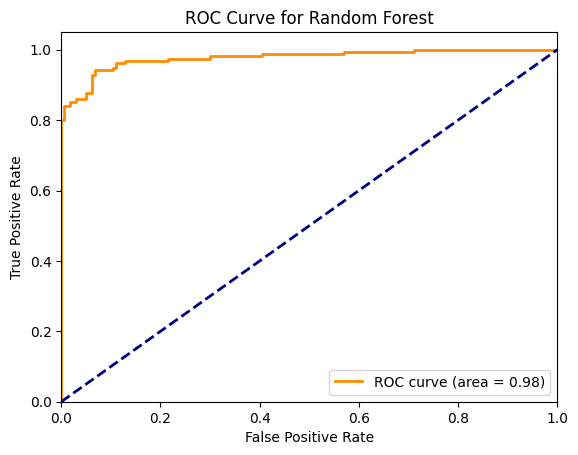

Gradient Boosting Metrics:
Accuracy: 0.9185
Precision: 0.9577
Recall: 0.8718
F1-Score: 0.9128
ROC-AUC: 0.9745


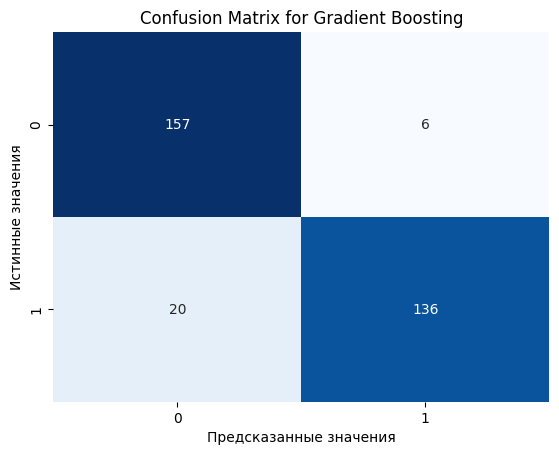

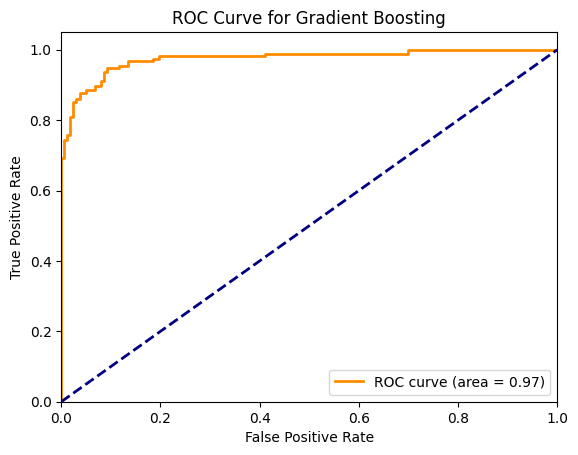

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Истинные значения')
    plt.show()

def plot_roc_curve(y_true, y_pred_proba, title):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

def evaluate_and_plot_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"{model_name} Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    
    plot_confusion_matrix(y_test, y_pred, f'Confusion Matrix for {model_name}')
    plot_roc_curve(y_test, y_pred_proba, f'ROC Curve for {model_name}')

evaluate_and_plot_model(logreg_best_model, X_test, y_test, 'Logistic Regression')
evaluate_and_plot_model(rf_best_model, X_test, y_test, 'Random Forest')
evaluate_and_plot_model(gb_best_model, X_test, y_test, 'Gradient Boosting')